In [1]:
import sys
assert sys.version_info >= (3, 6), "Sonnet 2 requires Python >=3.6"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree
import pandas as pd

try:
  import sonnet.v2 as snt
  tf.enable_v2_behavior()
except ImportError:
  import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.3.1
Sonnet version 2.0.0


In [3]:
!pwd

/Users/tuckerkj/git/quantumML/python


In [4]:
is_data = pd.read_table('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_data.txt', delimiter=' ', usecols=range(10)).values
is_train = is_data[0:7999]
is_test = is_data[8000:9999]

In [5]:
is_train.shape

(7999, 10)

In [6]:
original_dim = is_train.shape[1]

In [7]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 100
batch_size = 128
latent_dim = 4
epochs = 50

embedding_dim = 10
num_embeddings = 4
beta = 0.25

In [8]:
class Encoder(snt.Module):
    def __init__(self, hdims, latent_dim, embedding_dim, name=None):
        super(Encoder, self).__init__(name)
        
        self.hidden = []
        for idx, hdim in enumerate(hdims):
            layer_name = 'hidden{}'.format(idx)
            self.hidden.append(snt.Linear(hdim, name=layer_name))
        
        self.z_e = snt.Linear(latent_dim*embedding_dim, name=layer_name)
        
    def __call__(self, x):
        
        # Run the input through the encoder network
        for hidden_layer in self.hidden:
            x = tf.nn.relu(hidden_layer(x))
        
        out_z_e = tf.reshape(self.z_e(x),[-1,latent_dim, embedding_dim])
        
        return {
            'z_e': out_z_e
        }

In [9]:
enc = Encoder([intermediate_dim], latent_dim, embedding_dim)

In [10]:
output = enc(is_train.astype(float))

In [11]:
output['z_e']

<tf.Tensor: shape=(7999, 4, 10), dtype=float64, numpy=
array([[[ 0.06490689,  0.32095812, -0.00262826, ..., -0.05759596,
          0.29314043, -0.81679056],
        [-0.44126815,  0.47272793,  0.77365208, ..., -0.41400583,
         -0.09129907, -0.27639824],
        [-0.17742458, -0.68920649,  0.27714234, ..., -0.79617607,
         -0.27685784,  0.48264037],
        [-1.1220101 ,  0.19078159,  0.38561117, ...,  0.41991296,
          0.09116456,  0.50313307]],

       [[ 0.21912848,  0.57274319, -0.55509676, ..., -0.35638224,
          0.2681439 , -0.82980375],
        [-0.22694154,  0.29776057,  0.50838117, ...,  0.00594199,
         -0.14898569, -0.63305297],
        [-0.49127568, -0.91273782,  0.53113012, ..., -1.35097515,
         -0.52446256,  0.74365748],
        [-0.73964469,  0.00978514,  0.28617415, ...,  0.13349464,
          0.25310185,  0.46159246]],

       [[ 0.25549741,  0.50671107, -0.65827513, ..., -0.40986468,
          0.49605263, -0.80557862],
        [-0.28296023,  

In [12]:
output['z_e'].shape

TensorShape([7999, 4, 10])

In [13]:
quant = snt.nets.VectorQuantizer(embedding_dim, num_embeddings, beta, dtype=tf.float64)

In [14]:
quant_output = quant(output['z_e'], True)

In [15]:
quant_output

{'quantize': <tf.Tensor: shape=(7999, 4, 10), dtype=float64, numpy=
 array([[[ 0.03911957,  0.23962866,  0.07728974, ..., -0.38322883,
           0.35298682, -0.47797127],
         [ 0.03911957,  0.23962866,  0.07728974, ..., -0.38322883,
           0.35298682, -0.47797127],
         [ 0.03911957,  0.23962866,  0.07728974, ..., -0.38322883,
           0.35298682, -0.47797127],
         [-0.43091474, -0.46174733, -0.36461951, ...,  0.10929408,
           0.36472882,  0.00356547]],
 
        [[ 0.03911957,  0.23962866,  0.07728974, ..., -0.38322883,
           0.35298682, -0.47797127],
         [ 0.03911957,  0.23962866,  0.07728974, ..., -0.38322883,
           0.35298682, -0.47797127],
         [ 0.03911957,  0.23962866,  0.07728974, ..., -0.38322883,
           0.35298682, -0.47797127],
         [-0.43091474, -0.46174733, -0.36461951, ...,  0.10929408,
           0.36472882,  0.00356547]],
 
        [[ 0.03911957,  0.23962866,  0.07728974, ..., -0.38322883,
           0.35298682, -0.4

In [16]:
class Decoder(snt.Module):
    def __init__(self, hdims, vdim, apply_sigmoid=False, name=None):
        super(Decoder, self).__init__(name)
        
        self.apply_sigmoid = apply_sigmoid
        
        self.hidden = []
        for idx, hdim in enumerate(hdims):
            layer_name = 'hidden{}'.format(idx)
            self.hidden.append(snt.Linear(hdim, name=layer_name))
            
        self.visible = snt.Linear(vdim, 'visible')
        
    def __call__(self, x):
        
        latent_dim = x.shape[1]
        embedding_dim = x.shape[2]
        x = tf.reshape(x, [-1, latent_dim*embedding_dim])
        
        for hidden_layer in self.hidden:
            x = tf.nn.relu(hidden_layer(x))
        
        if self.apply_sigmoid:
            output = tf.nn.sigmoid(self.visible(x))
        else:
            output = self.visible(x)
        
        return output

In [17]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)

    return tf.reduce_sum(
        -.5 * ((sample - mean) ** tf.cast(2., tf.float64) * tf.cast(tf.exp(-logvar), tf.float64) + logvar + log2pi),
        axis=raxis)

In [18]:
class VQVAE(snt.Module):
    def __init__(self, encoder, quantizer, decoder, name=None):
        super(VQVAE, self).__init__(name)
        
        self.encoder = encoder
        self.quantizer = quantizer
        self.decoder = decoder
    
    def __call__(self, x, is_training):
        # Run the encoder and decoder
        encoder_output = self.encoder(x)
        quant_output = self.quantizer(encoder_output['z_e'], is_training)
        x_recon = self.decoder(quant_output['quantize'])
        
        # Compute the loss function
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_recon, labels=x)
        log_pxz = -tf.reduce_sum(cross_ent, axis=1)
        x_recon_loss = -tf.reduce_mean(log_pxz)
        loss = x_recon_loss + quant_output['loss']
        
        return {
            'x_recon': x_recon,
            'x_recon_loss': x_recon_loss,
            'loss': loss
        }

In [19]:
dec = Decoder([intermediate_dim], original_dim, True)

In [20]:
out_vae = dec(quant_output['quantize'])

In [21]:
out_vae

<tf.Tensor: shape=(7999, 10), dtype=float64, numpy=
array([[0.49465135, 0.46049857, 0.52806901, ..., 0.53028163, 0.43210137,
        0.59030813],
       [0.49465135, 0.46049857, 0.52806901, ..., 0.53028163, 0.43210137,
        0.59030813],
       [0.50701811, 0.49700119, 0.54873792, ..., 0.52527428, 0.44169645,
        0.56659727],
       ...,
       [0.49465135, 0.46049857, 0.52806901, ..., 0.53028163, 0.43210137,
        0.59030813],
       [0.50581306, 0.52110644, 0.46859938, ..., 0.49943901, 0.49537106,
        0.48569845],
       [0.49465135, 0.46049857, 0.52806901, ..., 0.53028163, 0.43210137,
        0.59030813]])>

In [22]:
vqvae = VQVAE(enc, quant, dec)

In [23]:
model_output = vqvae(is_test.astype(float), False)

In [24]:
model_output

{'x_recon': <tf.Tensor: shape=(1999, 10), dtype=float64, numpy=
 array([[0.49487553, 0.56760153, 0.52814549, ..., 0.52109625, 0.49074797,
         0.53544014],
        [0.50701811, 0.49700119, 0.54873792, ..., 0.52527428, 0.44169645,
         0.56659727],
        [0.53315666, 0.53817374, 0.50713943, ..., 0.48416179, 0.48606323,
         0.53991081],
        ...,
        [0.49465135, 0.46049857, 0.52806901, ..., 0.53028163, 0.43210137,
         0.59030813],
        [0.5145187 , 0.54100779, 0.44556952, ..., 0.46407383, 0.48825195,
         0.44169261],
        [0.50701811, 0.49700119, 0.54873792, ..., 0.52527428, 0.44169645,
         0.56659727]])>,
 'x_recon_loss': <tf.Tensor: shape=(), dtype=float64, numpy=7.263240560010053>,
 'loss': <tf.Tensor: shape=(), dtype=float64, numpy=7.538617642491322>}

## Training

In [25]:
#@title Utility function to show progress bar.
from tqdm import tqdm

num_meas = is_train.shape[0]

def progress_bar(generator):
  return tqdm(
      generator,
      unit='measurements',
      unit_scale=batch_size,
      total=(num_meas // batch_size) * epochs)

In [43]:
# network parameters
learning_rate = 3e-4
input_shape = (original_dim, )
batch_size = 128
epochs = 50

# F = 0.9322 (continuous)
#intermediate_dim = [500, 500]
#latent_dim = 10

# F = 0.9255 (continuous)
#intermediate_dim = [100]
#latent_dim = 4

# F = 0.9080
intermediate_dim = [100]
latent_dim = 2
embedding_dim = 10
num_embeddings = 11
beta = 0.25

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

enc = Encoder(intermediate_dim, latent_dim, embedding_dim)
quant = snt.nets.VectorQuantizer(embedding_dim, num_embeddings, beta, dtype=tf.float64)
dec = Decoder(intermediate_dim, original_dim, apply_sigmoid=False)
vqvae = VQVAE(enc, quant, dec)

@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        model_output = vqvae(tf.cast(data, tf.float64), True)
    
    trainable_variables = vqvae.trainable_variables
    grads = tape.gradient(model_output['loss'], trainable_variables)
    optimizer.apply(grads, trainable_variables)
    
    return model_output

In [44]:
# Get data sliced for SGD
train_dataset = (
    tf.data.Dataset.from_tensor_slices(is_train)
    .shuffle(1000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(is_test)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

In [45]:
# Train
num_training_updates = 20000

train_losses = []
recon_losses = []
for step_index, data in enumerate(train_dataset):
    train_results = train_step(data)
    train_losses.append(train_results['loss'])
    recon_losses.append(train_results['x_recon_loss'])
    
    if (step_index + 1) % 100 == 0:
        print('%d loss: %f recon loss: %f' % (step_index+1, np.mean(train_losses[-100:]), np.mean(recon_losses[-100:])))
        
    if (step_index + 1) % num_training_updates == 0:
        break

100 loss: 6.897026 recon loss: 6.629003
200 loss: 7.187538 recon loss: 5.878361
300 loss: 8.627937 recon loss: 5.242890
400 loss: 9.659221 recon loss: 4.784660
500 loss: 10.781037 recon loss: 4.202626
600 loss: 13.040941 recon loss: 3.786712
700 loss: 14.307596 recon loss: 3.546335
800 loss: 15.724627 recon loss: 3.374083
900 loss: 17.253974 recon loss: 3.268934
1000 loss: 18.308150 recon loss: 3.170133
1100 loss: 19.338067 recon loss: 3.106248
1200 loss: 20.586308 recon loss: 3.005215
1300 loss: 21.631978 recon loss: 2.872701
1400 loss: 22.527809 recon loss: 2.792553
1500 loss: 23.679648 recon loss: 2.725710
1600 loss: 24.995680 recon loss: 2.652191
1700 loss: 26.313008 recon loss: 2.601302
1800 loss: 27.564631 recon loss: 2.541669
1900 loss: 28.298667 recon loss: 2.500237
2000 loss: 29.115850 recon loss: 2.453756
2100 loss: 30.062607 recon loss: 2.417215
2200 loss: 30.850332 recon loss: 2.401689
2300 loss: 31.454307 recon loss: 2.333796
2400 loss: 32.377945 recon loss: 2.306098
2500 

19500 loss: 25.547898 recon loss: 1.403822
19600 loss: 25.316496 recon loss: 1.410056
19700 loss: 25.071679 recon loss: 1.416237
19800 loss: 24.705669 recon loss: 1.397105
19900 loss: 24.474607 recon loss: 1.400039
20000 loss: 24.049014 recon loss: 1.388269


In [46]:
# Look at validation set
model_output = vqvae(is_test.astype(float), False)
print(model_output)

{'x_recon': <tf.Tensor: shape=(1999, 10), dtype=float64, numpy=
array([[ 12.31866099,  -4.79606024,  -9.7049797 , ...,  -6.83148732,
        -10.1863457 ,  -6.77103136],
       [ 14.52744819,   1.95446454,   0.72390414, ...,   2.18414654,
         24.52757937,   5.47527183],
       [  7.55395311,  -1.3842059 ,  -0.74049081, ...,  -3.17178538,
         11.24057215, -19.73339099],
       ...,
       [  9.3891657 ,  -4.61758927,  -7.3913665 , ...,   6.32081079,
          2.28054951,  19.16069651],
       [ 14.18767357,  10.40178274,  11.53290977, ...,  -2.06430933,
        -10.86926885,  -7.11388791],
       [  8.43226608,   0.96850759,   4.27520729, ...,   1.65655511,
        -21.75641288,  -3.96428666]])>, 'x_recon_loss': <tf.Tensor: shape=(), dtype=float64, numpy=1.5545598485415124>, 'loss': <tf.Tensor: shape=(), dtype=float64, numpy=25.359089635058993>}


# Train The Prior

In [47]:
sys.path.append('models')
import vae

In [51]:
# Run the training set through the trained encoder and quantizer
encoder_output = vqvae.encoder(tf.cast(is_train, dtype=tf.dtypes.float64))
quant_output = vqvae.quantizer(encoder_output['z_e'], False)
prior_train = quant_output['encoding_indices']

In [52]:
# Run the test set through the trained encoder and quantizer
encoder_output = vqvae.encoder(tf.cast(is_test, dtype=tf.dtypes.float64))
quant_output = vqvae.quantizer(encoder_output['z_e'], False)
prior_test = quant_output['encoding_indices']

In [53]:
# Get data sliced for SGD
train_dataset = (
    tf.data.Dataset.from_tensor_slices(prior_train)
    .shuffle(1000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))

valid_dataset = (
    tf.data.Dataset.from_tensor_slices(prior_test)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

In [54]:
# Use the quantized training set to train a new CatVAE

# network parameters
depth = num_embeddings

# F = 0.9322
#intermediate_dim = [500, 500]
#latent_dim = 10

# F = 0.9255
#intermediate_dim = [100]
#latent_dim = 4

# F = 0.8989
prior_intermediate_dim = [100]
prior_latent_dim = 2

optimizer = snt.optimizers.Adam(learning_rate=learning_rate)

enc = vae.CatEncoder(prior_intermediate_dim, prior_latent_dim, depth)
dec = vae.CatDecoder(prior_intermediate_dim, latent_dim, depth)
catvae = vae.CatVAE(enc, dec)

@tf.function
def prior_train_step(data):
    with tf.GradientTape() as tape:
        model_output = catvae(tf.cast(data, tf.int32))
    
    trainable_variables = catvae.trainable_variables
    grads = tape.gradient(model_output['loss'], trainable_variables)
    optimizer.apply(grads, trainable_variables)
    
    return model_output

In [55]:
# Train
num_training_updates = 20000

train_losses = []
recon_losses = []
for step_index, data in enumerate(train_dataset):
    train_results = prior_train_step(data)
    train_losses.append(train_results['loss'])
    recon_losses.append(train_results['x_recon_loss'])
    
    if (step_index + 1) % 100 == 0:
        print('%d loss: %f recon loss: %f' % (step_index+1, np.mean(train_losses[-100:]), np.mean(recon_losses[-100:])))
        
    if (step_index + 1) % num_training_updates == 0:
        break

100 loss: 4.786425 recon loss: 4.750347
200 loss: 4.571550 recon loss: 4.543808
300 loss: 4.548227 recon loss: 4.515097
400 loss: 4.521246 recon loss: 4.470695
500 loss: 4.509253 recon loss: 4.438515
600 loss: 4.498761 recon loss: 4.397486
700 loss: 4.467043 recon loss: 4.324600
800 loss: 4.445143 recon loss: 4.231230
900 loss: 4.406083 recon loss: 4.104348
1000 loss: 4.384161 recon loss: 4.013093
1100 loss: 4.361784 recon loss: 3.935763
1200 loss: 4.351132 recon loss: 3.889733
1300 loss: 4.334208 recon loss: 3.833026
1400 loss: 4.329292 recon loss: 3.807965
1500 loss: 4.318402 recon loss: 3.777065
1600 loss: 4.316991 recon loss: 3.756959
1700 loss: 4.311509 recon loss: 3.741301
1800 loss: 4.309892 recon loss: 3.724164
1900 loss: 4.302194 recon loss: 3.702677
2000 loss: 4.303265 recon loss: 3.685573
2100 loss: 4.301583 recon loss: 3.680858
2200 loss: 4.297765 recon loss: 3.658728
2300 loss: 4.297148 recon loss: 3.653062
2400 loss: 4.294237 recon loss: 3.644850
2500 loss: 4.290600 recon

# Reconstruct the State

In [59]:
def bit_array(a):
    aa = []
    for c in a:
        if c == '0':
            aa.append(0)
        else:
            aa.append(1)
        
    return np.array(aa)

def bin_to_dec(b):
    dec = 0
    for idx, val in enumerate(b):
        dec += val << (len(b) - idx - 1)
        
    return dec

def update_counts(psi, vqvae, catvae, batch_size):
    # Sample in the CatVAE latent space using the prior and decode to get distributions by site
    prior_latent_dim = catvae.encoder.latent_dim
    z = tf.random.normal([batch_size, prior_latent_dim], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
    output = catvae.decoder(z)
    vdim = output['x_recon'].shape[1]
    
    # Sample from the resulting distributions
    probs = tf.reshape(output['x_recon'], [-1, output['x_recon'].shape[-1]])
    samples = tf.reshape(tf.random.categorical(tf.math.log(probs), 1), [batch_size, vdim]).numpy()
    
    # Get the embedding vectors from the quantizer and run them through the decoder
    embeddings = vqvae.quantizer.quantize(samples)
    output = tf.nn.sigmoid(vqvae.decoder(embeddings))
    
    # Sample from the binary distributions coming out of the decoder to get spins
    eps = tf.random.uniform(output.shape, minval=0, maxval=1, dtype=tf.dtypes.float64)
    meas_int = tf.cast(tf.math.greater_equal(output, eps), tf.int32).numpy()
    
    # Count the spins that came out
    for ii in range(meas_int.shape[0]):
        idx = bin_to_dec(meas_int[ii,:])
        psi[idx] += 1

def get_psi(vqvae, catvae, num_samples):
    n = vqvae.encoder.hidden[0].input_size
    psi = np.zeros(2**n)
    batch_size = 1000
    total_samples = 0
    while total_samples < num_samples:
        update_counts(psi, vqvae, catvae, batch_size)
        total_samples = total_samples + batch_size
        
        if total_samples % 100000 == 0:
            print(total_samples)
        
    # Normalize
    psi = np.sqrt(psi*(1.0/float(total_samples)))
    
    return psi

In [64]:
psi = get_psi(vqvae, catvae, 1000000)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [65]:
np.dot(psi, psi)

1.0

In [66]:
psi

array([0.29378393, 0.12348684, 0.08542833, ..., 0.07972453, 0.15172014,
       0.27493999])

In [67]:
# Save the wave function
np.savetxt('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/ld_results/vq_vae_psi_2d.txt', psi)


# Debug

In [206]:
cout = tf.random.categorical(tf.math.log([[1/3.0,1/3.0,1]]), 100000)

In [207]:
cout.shape

TensorShape([1, 100000])

(array([0.297525, 0.29988 , 0.902595]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

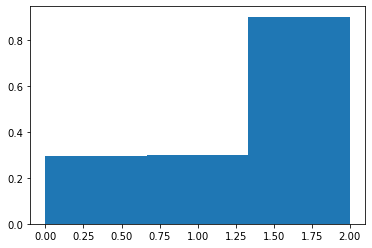

In [208]:
plt.hist(np.transpose(cout.numpy()), bins=3, density=True)

# Results

In [151]:
def bit_array(a):
    aa = []
    for c in a:
        if c == '0':
            aa.append(0)
        else:
            aa.append(1)
        
    return np.array(aa)

def bin_to_dec(b):
    dec = 0
    for idx, val in enumerate(b):
        dec += val << (len(b) - idx - 1)
        
    return dec

def update_counts(psi, vae, batch_size, latent_dim, num_embeddings):
    #latent_dim = vae.decoder.hidden[0].input_size
    encoding_indices = tf.random.uniform([batch_size, latent_dim], minval=0, maxval=num_embeddings, dtype=tf.dtypes.int32)
    z = vae.quantizer.quantize(encoding_indices)
    output = tf.nn.sigmoid(vae.decoder(z))
    
    #meas = tf.math.round(tf.nn.sigmoid(vae.decoder(z)))
    #meas_int = meas.numpy().astype(int)
    
    eps = tf.random.uniform(output.shape, minval=0, maxval=1, dtype=tf.dtypes.float64)
    meas_int = tf.cast(tf.math.greater_equal(output, eps), tf.int32).numpy()
    
    for ii in range(meas_int.shape[0]):
        idx = bin_to_dec(meas_int[ii,:])
        psi[idx] += 1

def get_psi(vae, num_samples, latent_dim, num_embeddings):
    n = vae.encoder.hidden[0].input_size
    psi = np.zeros(2**n)
    batch_size = 1000
    total_samples = 0
    while total_samples < num_samples:
        update_counts(psi, vae, batch_size, latent_dim, num_embeddings)
        total_samples = total_samples + batch_size
        
        if total_samples % 100000 == 0:
            print(total_samples)
        
    # Normalize
    psi = np.sqrt(psi*(1.0/float(total_samples)))
    
    return psi

import math
def get_psi_loss(vae, num_samples):
    n = vae.encoder.hidden[0].input_size
    norm = 0
    psi = []
    for d in range(2**n):
        dbin = bit_array(np.binary_repr(d, width=n))
        dbin_input = np.tile(dbin, (num_samples,1))
        model_output = vae(dbin_input.astype(float), False)
        val = np.exp(-0.5*model_output['loss'])
        psi.append(val)
        norm = norm + val*val
    norm = math.sqrt(norm)
    
    for ii in range(len(psi)):
        psi[ii] = psi[ii]/norm
        
    return np.array(psi)

In [167]:
psi = get_psi(vae, 1000000, latent_dim, num_embeddings)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [152]:
psi = get_psi_loss(vae, 100)

In [168]:
np.dot(psi, psi)

1.0

In [169]:
psi

array([0.06286493, 0.05860034, 0.02302173, ..., 0.03388215, 0.059279  ,
       0.07390534])

In [150]:
# Save the wave function
np.savetxt('/Users/tuckerkj/Google Drive/Research/QML/data/quc_examples/Tutorial1_TrainPosRealWaveFunction/ld_results/vq_vae_psi_4d.txt', psi)


In [235]:
model_output = vae(tf.constant([[1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0]], dtype=tf.dtypes.float64), False)
tf.nn.sigmoid(model_output['x_recon'])

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[9.99999998e-01, 9.99832452e-01, 3.88153379e-05, 1.23308660e-01,
        8.22105859e-04, 3.03396258e-01, 7.60546807e-02, 5.40437299e-01,
        9.99388982e-01, 9.98755929e-01]])>

In [249]:
idx = 4
model_output = vae(tf.constant([is_test[idx,:]], dtype=tf.dtypes.float64), False)
print(is_test[idx,:])
tf.nn.sigmoid(model_output['x_recon'])

[1 1 1 0 0 0 0 0 0 0]


<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[9.99999999e-01, 9.95067153e-01, 9.99999996e-01, 4.97837346e-01,
        1.86698696e-05, 1.01609373e-03, 2.72384370e-06, 1.43693769e-03,
        2.08595918e-02, 2.91849690e-02]])>

In [257]:
tf.one_hot(tf.constant([[2,2],[1,3]]), 4)

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 1., 0., 0.],
        [0., 0., 0., 1.]]], dtype=float32)>

# Latent Space Visualization

In [435]:
def plot_qvae_results(vae, z_min, z_max, frame_size = 0, fig_size = 10, fig_bkgrnd = 1):
    """Plots spins as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        frame_size: width of space between spin images
    """

    #encoder, decoder = models
    #x_test, y_test = data
    #os.makedirs(model_name, exist_ok=True)

    #filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    #z_mean, _, _ = encoder.predict(x_test,
    #                               batch_size=batch_size)
    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    #plt.colorbar()
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.savefig(filename)
    #plt.show()

    #filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of spin distributions
    n = 30
    digit_size = 10
    figure = np.zeros(((frame_size + digit_size) * n + frame_size,
                       (frame_size + digit_size) * n + frame_size)) + fig_bkgrnd
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(z_min[0], z_max[0], n)
    grid_y = np.linspace(z_min[1], z_max[1], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = tf.constant([[xi, yi]], dtype=tf.dtypes.float64)
            x_decoded = tf.nn.sigmoid(vae.decoder(z_sample)).numpy()
            #print(x_decoded[0].shape)
            digit = np.stack([x_decoded[0] for ii in range(digit_size)]).reshape(digit_size, digit_size)
            figure[i * (frame_size + digit_size) + frame_size: (i + 1) * (digit_size + frame_size),
                   j * (frame_size + digit_size) + frame_size: (j + 1) * (digit_size + frame_size)] = digit

    plt.figure(figsize=(fig_size, fig_size))
    start_range = (digit_size + frame_size) // 2
    end_range = (n - 1) * (digit_size + frame_size) + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size + frame_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='gray', vmin=0, vmax=1)
    #plt.savefig(filename)
    plt.show()

In [436]:
def plot_qvae_latent(vae, z):
    """Plots spins for the given 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        z (tuple): latent vector
    """

    #encoder, decoder = models

    img_height = 10

    z_sample = tf.constant([z], dtype=tf.dtypes.float64)
    x_decoded = tf.nn.sigmoid(vae.decoder(z_sample)).numpy()
    spin_img = np.stack([x_decoded[0] for ii in range(img_height)]).reshape(img_height, img_height)

    #print(spin_img)

    plt.figure(figsize=(10, 4))
    plt.imshow(spin_img, cmap='gray', vmin=0, vmax=1)
    plt.show()

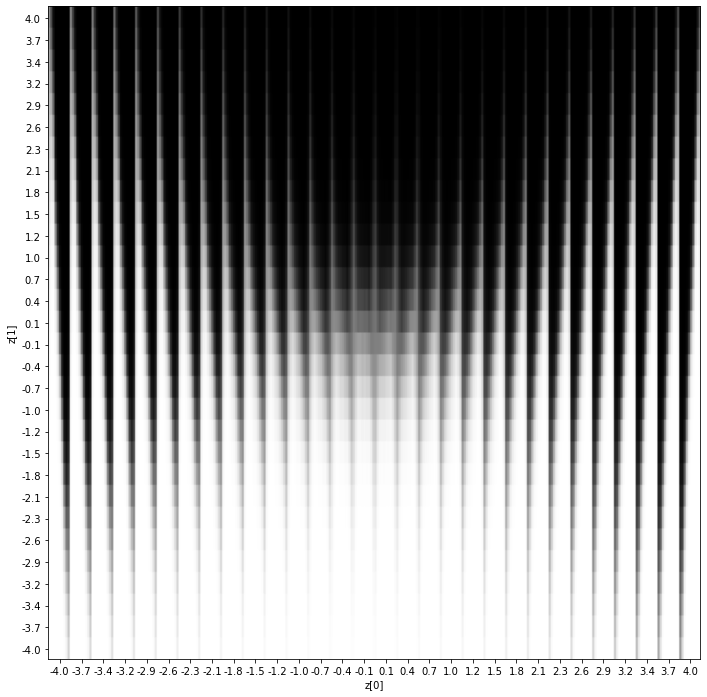

In [437]:
plot_qvae_results(vae, [-4,-4], [4,4], 0, 12, 0.3)

# Scratch

In [34]:
a = ['a','b','c']
for idx, val in enumerate(a):
    print(idx, val)

0 a
1 b
2 c


In [21]:
lin = snt.Linear(intermediate_dim, name='test_lin')

In [27]:
lin(is_train.astype(float))

<tf.Tensor: shape=(7999, 100), dtype=float64, numpy=
array([[-0.46892147, -0.34728384, -0.74378709, ...,  0.29133378,
        -0.26331127,  0.37414721],
       [-0.04339453,  0.07576071, -1.16743727, ...,  0.93418193,
         0.12609772,  0.85569389],
       [ 0.02504136,  0.50216652, -1.25031824, ...,  0.6404713 ,
         0.64565024,  0.74596843],
       ...,
       [ 0.15872905,  0.34844972, -1.76310892, ...,  0.21092538,
         0.73613504,  0.02295605],
       [ 0.31660287,  0.42498682, -0.7207022 , ..., -0.56906129,
         0.97862829, -0.26926874],
       [ 1.17475972,  0.32786622, -1.34069384, ...,  0.04867342,
         0.99408893, -0.87915178]])>